In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset, fit_dset_to_m, make_grid_dataset
from controls import LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories, plot_experiment_new
from models import save_model, load_model
from experiments import run_experiment, save_experiment, load_experiment
import params
from IPython.display import HTML
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

######################
### DISPLAY CONFIG ###
######################
for name, values in vars(params).items():
    print(name, values)

torch.set_default_device("cuda")
#torch.set_default_device("cpu")

%load_ext autoreload
%autoreload 2

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:116: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$(V \circ E)(x)$ and $f(x, (\pi\circ E)(x))$, $\dot{x}_1=x_1=0$", fontsize=16)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:117: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel("$\dot{x}_2$", fontsize=16, labelpad=-8)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:123: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$(V \circ E)(x)$ and $f(x, (\pi\circ E)(x))$, $\dot{x}_1=\dot{x}_2=0$", fontsize=16)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:126: SyntaxWarning: invalid escape sequence '\p'
  ax.quiver(XXb.cpu().detach().numpy(), YYb.cpu().

__name__ params
__doc__ None
__package__ 
__loader__ <_frozen_importlib_external.SourceFileLoader object at 0x7f236a0fb830>
__spec__ ModuleSpec(name='params', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f236a0fb830>, origin='/home1/lutkus/latent_space/cartpole_lyapunov/params.py')
__file__ /home1/lutkus/latent_space/cartpole_lyapunov/params.py
__cached__ /home1/lutkus/latent_space/cartpole_lyapunov/__pycache__/params.cpython-313.pyc
__builtins__ {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_impor

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None, expert_controller=False)
#data = make_grid_dataset([0.5, 0.5, 0.5, 0.5], [3], 10)
#data = make_grid_dataset(params.grid_x_ranges, params.grid_u_ranges, params.grid_n_per_axis)
data = load_dataset(fname='custom-drift_match-500k.pkl')
print(data[0][0].shape, data[1][0].shape)
#data = load_dataset(fname=params.dataset)
#print(data[0][0].shape, data[1][0].shape)
X, U, Xtest, Utest = data
'''
data_rand = load_dataset(fname=params.dataset2)
X0, U0 = fit_dset_to_m(X[0], U[0])
X = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))
U = (torch.vstack([U0,data_rand[1][0]]), None)
Xtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])
Xtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))
Utest = (torch.vstack([Utest0,data_rand[3][0]]), None)
print("DSET SIZES:")
print(X[0].shape)
print(X[1].shape)
'''

torch.Size([500000, 10, 4]) torch.Size([500000, 9, 1])


'\ndata_rand = load_dataset(fname=params.dataset2)\nX0, U0 = fit_dset_to_m(X[0], U[0])\nX = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))\nU = (torch.vstack([U0,data_rand[1][0]]), None)\nXtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])\nXtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))\nUtest = (torch.vstack([Utest0,data_rand[3][0]]), None)\nprint("DSET SIZES:")\nprint(X[0].shape)\nprint(X[1].shape)\n'

9
original state:
 [(0, 1, 3), (2,)]
n_combinations 4
n_params 2
{'ae': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), (

  3%|▎         | 1/30 [00:12<06:05, 12.60s/it]

ep 0: train 0.24562819302082062    test 7.914026260375977
rec 0.05016183480620384    mstep 0.19546616077423096    jac 0.0
horizon is now 2


  7%|▋         | 2/30 [00:25<06:01, 12.92s/it]

it: 2; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 3


 10%|█         | 3/30 [00:45<07:15, 16.12s/it]

horizon is now 4


 13%|█▎        | 4/30 [01:04<07:25, 17.15s/it]

0.017165985
it: 4; avg reward: 328.83993403196536; completion rate: 0.01; gamma_max: 0.017165984958410263
horizon is now 5


 17%|█▋        | 5/30 [01:29<08:23, 20.16s/it]

horizon is now 6


 20%|██        | 6/30 [01:54<08:39, 21.64s/it]

0.08367128
it: 6; avg reward: 748.9283665360729; completion rate: 0.01; gamma_max: 0.08367127925157547
horizon is now 7


 23%|██▎       | 7/30 [02:25<09:28, 24.72s/it]

horizon is now 8


 27%|██▋       | 8/30 [02:55<09:40, 26.39s/it]

it: 8; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 9


 33%|███▎      | 10/30 [04:04<10:09, 30.45s/it]

it: 10; avg reward: 0; completion rate: 0.0; gamma_max: 0


 40%|████      | 12/30 [05:14<09:46, 32.61s/it]

it: 12; avg reward: 0; completion rate: 0.0; gamma_max: 0


 47%|████▋     | 14/30 [06:24<08:58, 33.67s/it]

0.07951579
it: 14; avg reward: 1665.977872619357; completion rate: 0.02; gamma_max: 0.07951579242944717


 53%|█████▎    | 16/30 [07:34<07:59, 34.27s/it]

it: 16; avg reward: 0; completion rate: 0.0; gamma_max: 0


 60%|██████    | 18/30 [08:45<06:56, 34.69s/it]

it: 18; avg reward: 0; completion rate: 0.0; gamma_max: 0


 67%|██████▋   | 20/30 [09:56<05:48, 34.82s/it]

0.051942524
it: 20; avg reward: 1040.0964591234301; completion rate: 0.01; gamma_max: 0.05194252356886864


 73%|███████▎  | 22/30 [11:06<04:38, 34.79s/it]

0.2464204
it: 22; avg reward: 4945.116155861401; completion rate: 0.0297029702970297; gamma_max: 0.24642039835453033


 80%|████████  | 24/30 [12:18<03:29, 34.99s/it]

0.008711411
it: 24; avg reward: 31.706319924808746; completion rate: 0.01; gamma_max: 0.00871141068637371


 87%|████████▋ | 26/30 [13:28<02:19, 34.91s/it]

0.11480525
it: 26; avg reward: 2723.455452352468; completion rate: 0.02; gamma_max: 0.11480525135993958


 93%|█████████▎| 28/30 [14:35<01:07, 33.91s/it]

0.17595543
it: 28; avg reward: 3401.895858721706; completion rate: 0.04; gamma_max: 0.17595542967319489


100%|██████████| 30/30 [15:46<00:00, 31.53s/it]

ep 29: train 0.0070772115141153336    test 0.004973500035703182
rec 0.00017960065451916307    mstep 0.006897616200149059    jac 0.0


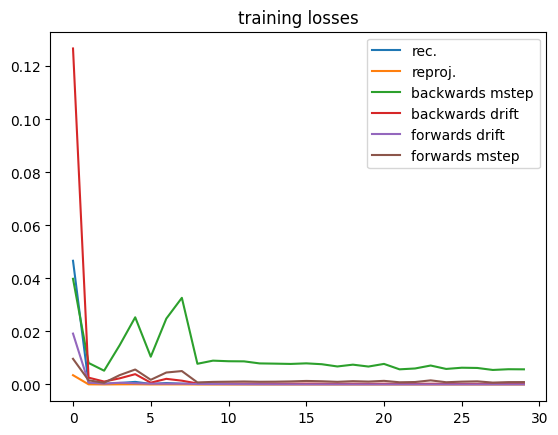

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is <function uniform_ at 0x7f236b1ef060>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is <function uniform_ at 0x7f236b1ef060>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f236b1ef6a0>
g bias init is <function zeros_ at 0x7f236b1ef420>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2

  3%|▎         | 1/30 [00:10<05:05, 10.53s/it]

ep 0: train 0.2837545573711395    test 11.733461380004883
rec 0.06001539155840874    mstep 0.223738893866539    jac 0.0
horizon is now 2


  7%|▋         | 2/30 [00:22<05:21, 11.47s/it]

it: 2; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 3


 10%|█         | 3/30 [00:39<06:16, 13.94s/it]

horizon is now 4


 13%|█▎        | 4/30 [00:56<06:38, 15.32s/it]

it: 4; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 5


 17%|█▋        | 5/30 [01:19<07:28, 17.93s/it]

horizon is now 6


 20%|██        | 6/30 [01:42<07:49, 19.57s/it]

it: 6; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 7


 23%|██▎       | 7/30 [02:10<08:37, 22.48s/it]

horizon is now 8


 27%|██▋       | 8/30 [02:38<08:53, 24.27s/it]

it: 8; avg reward: 0; completion rate: 0.0; gamma_max: 0
horizon is now 9


 33%|███▎      | 10/30 [03:41<09:19, 27.97s/it]

0.12762156
it: 10; avg reward: 1116.0688113399995; completion rate: 0.4117647058823529; gamma_max: 0.12762156128883362


 40%|████      | 12/30 [04:51<09:22, 31.23s/it]

0.12101611
it: 12; avg reward: 1353.7546047297315; completion rate: 0.71; gamma_max: 0.12101610749959946


 47%|████▋     | 14/30 [06:01<08:44, 32.76s/it]

0.10018004
it: 14; avg reward: 1130.1587782022839; completion rate: 0.68; gamma_max: 0.10018003731966019


 53%|█████▎    | 16/30 [07:11<07:48, 33.46s/it]

0.114220984
it: 16; avg reward: 1782.0381675286867; completion rate: 0.69; gamma_max: 0.1142209842801094


 60%|██████    | 18/30 [08:21<06:46, 33.89s/it]

0.15695909
it: 18; avg reward: 1852.9330078663652; completion rate: 0.64; gamma_max: 0.15695908665657043


 67%|██████▋   | 20/30 [09:31<05:39, 33.98s/it]

0.10387028
it: 20; avg reward: 2527.092276169906; completion rate: 0.53; gamma_max: 0.10387028008699417


 73%|███████▎  | 22/30 [10:39<04:30, 33.80s/it]

0.12689666
it: 22; avg reward: 2068.2778422200754; completion rate: 0.69; gamma_max: 0.1268966645002365


 80%|████████  | 24/30 [11:49<03:23, 33.94s/it]

0.14507647
it: 24; avg reward: 1969.7389612967063; completion rate: 0.55; gamma_max: 0.1450764685869217


 87%|████████▋ | 26/30 [12:58<02:15, 33.90s/it]

0.1379243
it: 26; avg reward: 1873.682977284212; completion rate: 0.58; gamma_max: 0.13792429864406586


 93%|█████████▎| 28/30 [14:07<01:07, 33.85s/it]

0.24465784
it: 28; avg reward: 1957.2366253404703; completion rate: 0.49; gamma_max: 0.24465784430503845


100%|██████████| 30/30 [15:18<00:00, 30.63s/it]

ep 29: train 0.008149346336722374    test 0.004099773243069649
rec 0.0001513152674306184    mstep 0.00799802877008915    jac 0.0


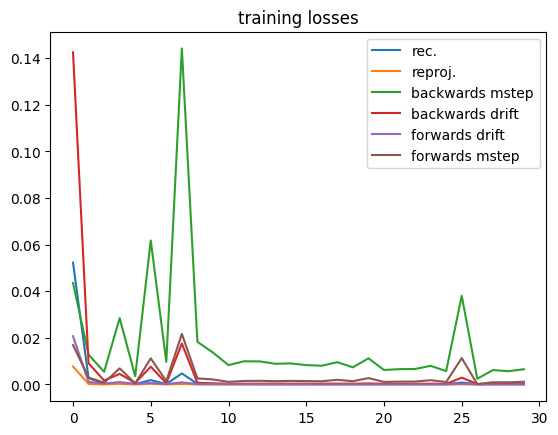

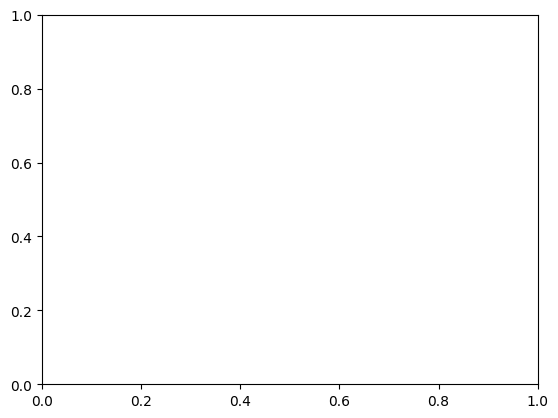

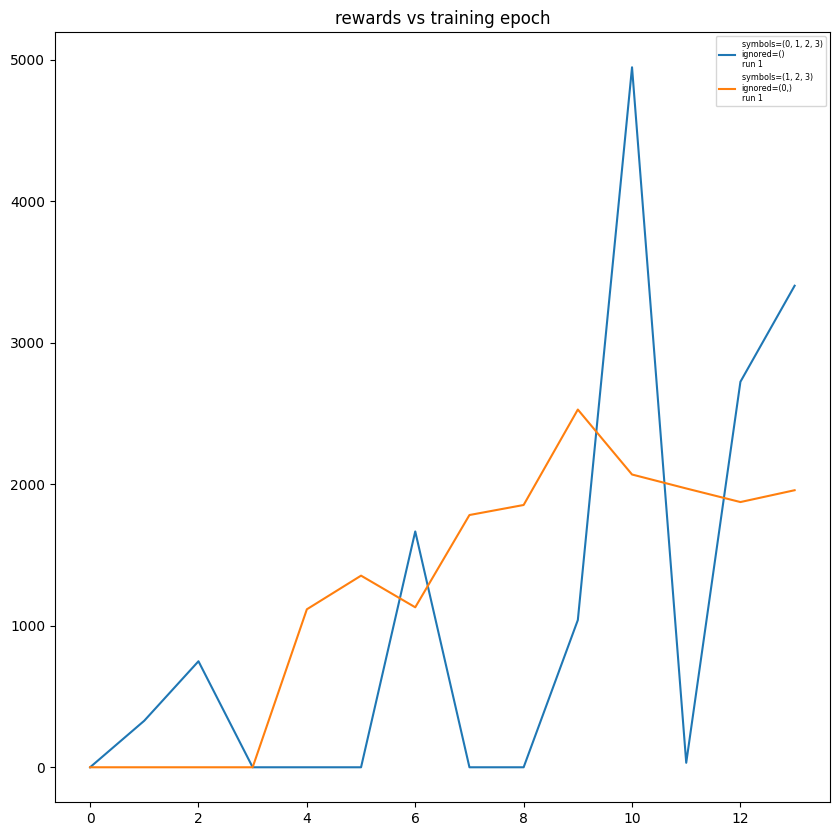

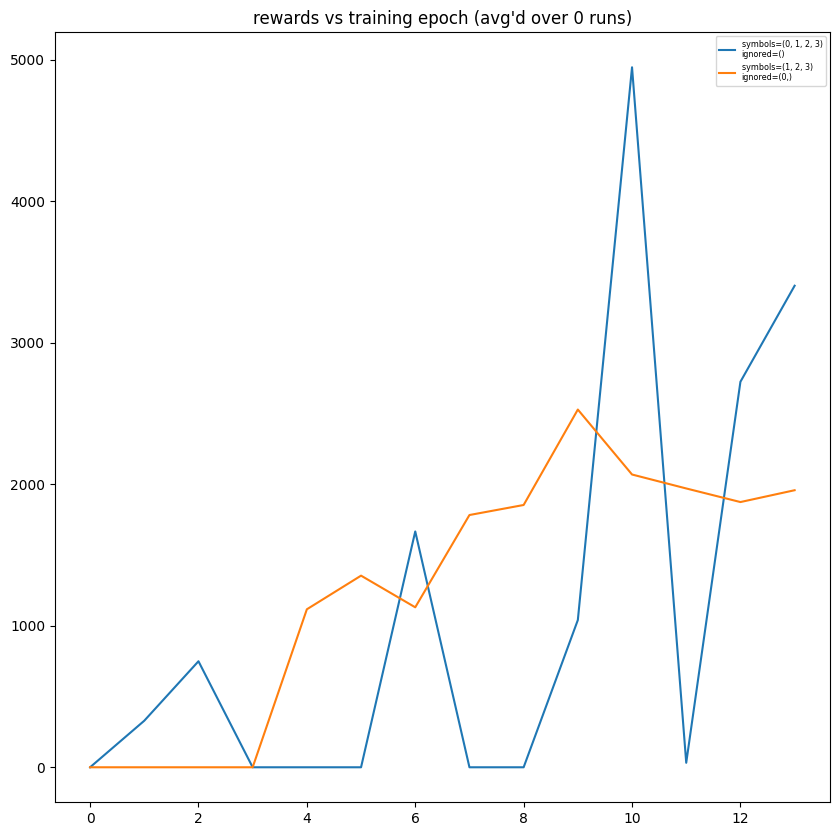

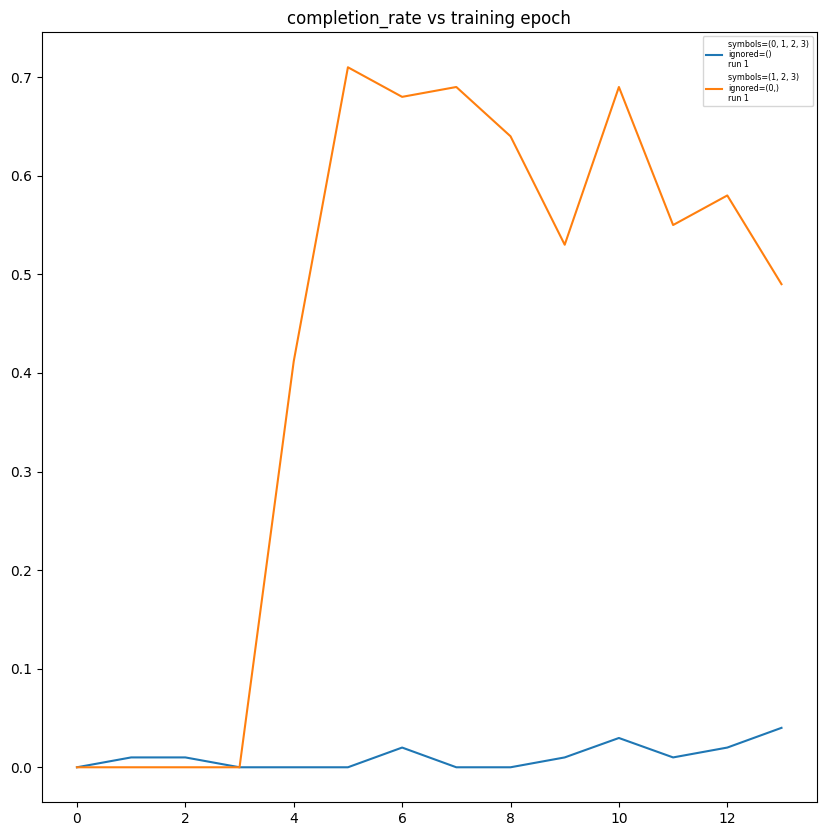

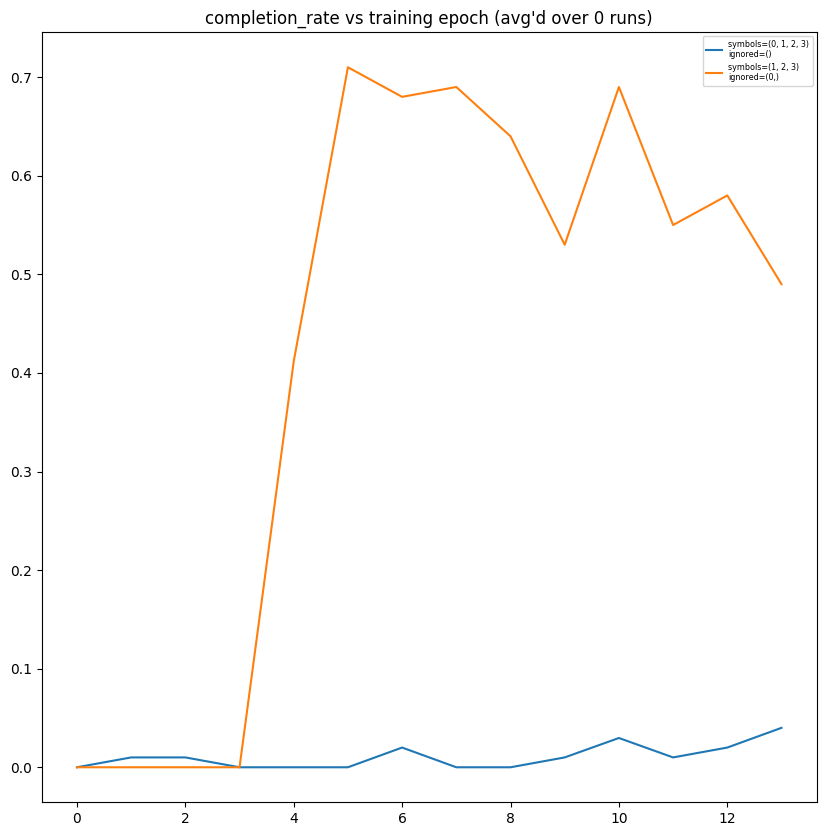

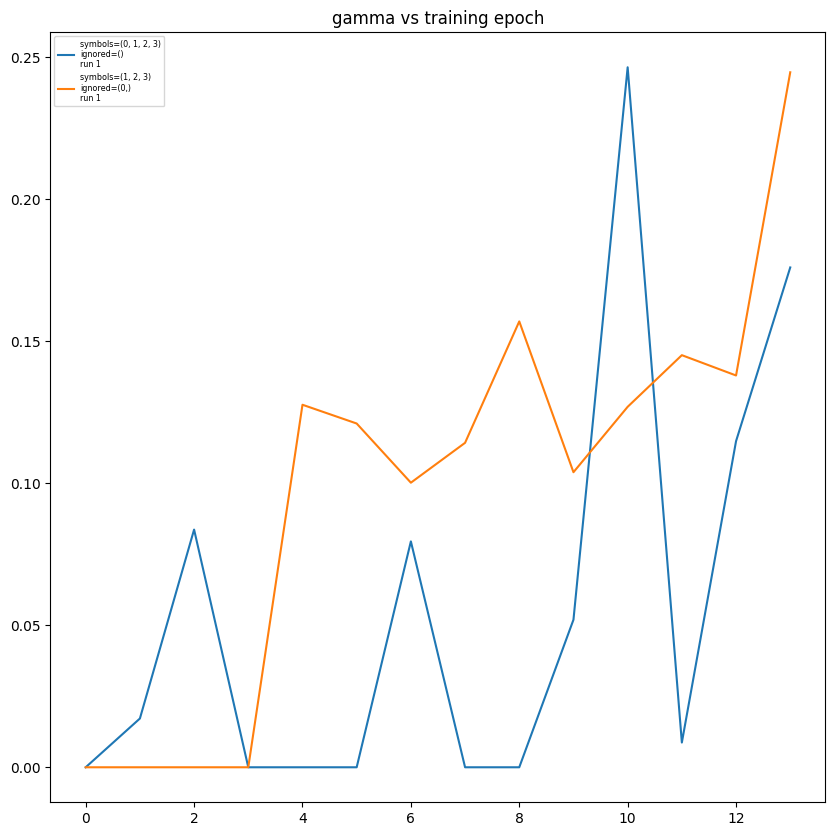

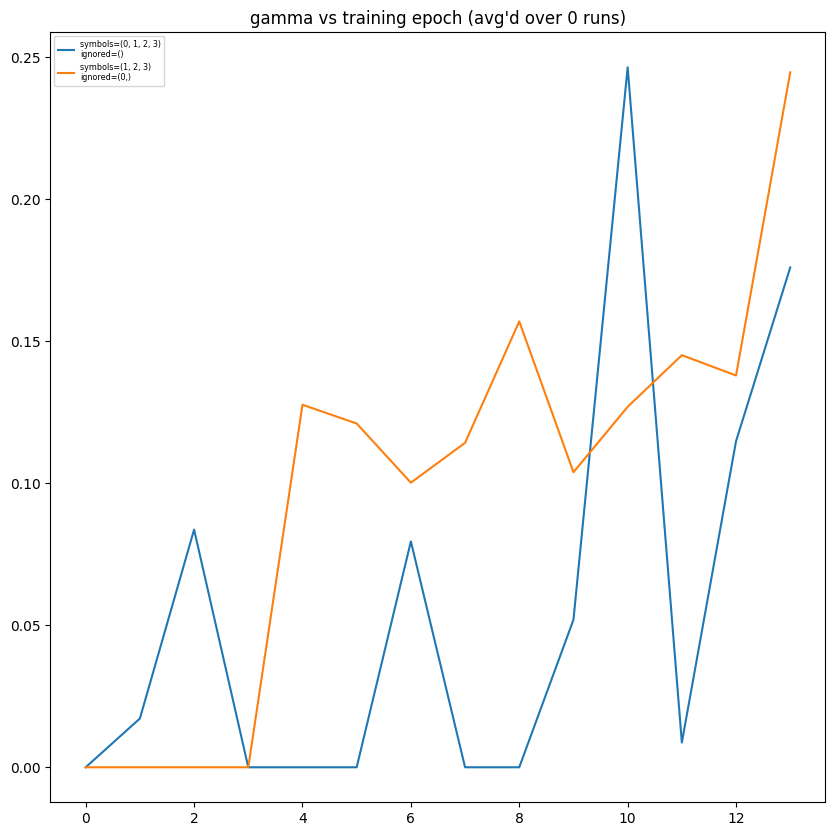

final state
 [(0, 1, 3), (2,)]
saving fwd_penalty_exp.pkl
9


In [3]:
from experiments import run_experiment_new
#spec = {'m':[3, 4, 5], 'rec_jac':[True, False, True], 'ptb_eps_x':[1e-9, 1e-6, 1e-3]}

'''
spec = {"predict_mstep" : [True, False, True], 
        "penalize_rec" : [True, True, True], 
        "penalize_reproj" : [False, True, True],
        "penalize_encoder_diagram_mstep" : [False, True, True]}
'''
name = 'fwd_penalty_exp'
'''
spec = {'m':[7, 8, 9],
        'm_schedule':[7*[0], 8*[0], 9*[0]]}
'''
spec = {'symbols': [(0,1,2,3), (0, 1, 3), (1, 2, 3), (1, 3)],
        'ignored': [(), (2,), (0,), (0, 2)]}
#n_runs = len(list(spec.items())[0][1])*[1]
n_runs = [1, 0, 1, 0]
print(params.m)
exp=run_experiment_new(data, spec, plot=True, n_runs=n_runs, fname=name, save=True)
print(params.m)


In [22]:
#######################
### Save Experiment ###
#######################

#save_name = 'nontrivial_2'
#save_experiment(save_name, exp)

saving nontrivial_2.pkl


In [ ]:
#######################
### Load Experiment ###
#######################

#name = "test_exp"
#name = "backwards-both_runs"
#name = 'both_runs'
#name = "small_pert"
#name = "extra_small_pert"
#name = "xxs_pert_exp"
#name = 'm-ablation'
#name = 'symbol-ablation-default_dataset'
#name = 'symbol-ablation-default_dataset_2'
#name = 'nontrivial_2'
name = 'fwd_penalty_exp'
exp = load_experiment(name)
plot_experiment_new(exp)

In [4]:
config_idx = 2#2
run_idx = 0#1
best_model_idx = np.argmax(exp['completion_rate'][config_idx][1][run_idx])
#best_model_idx = np.argmin(exp['gamma'][config_idx][1][run_idx])
#best_model_idx = 79 #-2
#best_model_idx = -1
print(best_model_idx)
ae = exp['ae_list'][config_idx][1][run_idx][best_model_idx]
fdyn = exp['fdyn_list'][config_idx][1][run_idx][best_model_idx]
ae.encode(torch.tensor([0.,0.,0.,0.]))

5


tensor([ 0.0027, -0.0015], device='cuda:0', grad_fn=<ViewBackward0>)

<unknown>:116: SyntaxWarning: invalid escape sequence '\c'
<unknown>:117: SyntaxWarning: invalid escape sequence '\d'
<unknown>:123: SyntaxWarning: invalid escape sequence '\c'
<unknown>:126: SyntaxWarning: invalid escape sequence '\p'
<unknown>:157: SyntaxWarning: invalid escape sequence '\p'
<unknown>:167: SyntaxWarning: invalid escape sequence '\c'
<unknown>:116: SyntaxWarning: invalid escape sequence '\c'
<unknown>:117: SyntaxWarning: invalid escape sequence '\d'
<unknown>:123: SyntaxWarning: invalid escape sequence '\c'
<unknown>:126: SyntaxWarning: invalid escape sequence '\p'
<unknown>:157: SyntaxWarning: invalid escape sequence '\p'
<unknown>:167: SyntaxWarning: invalid escape sequence '\c'


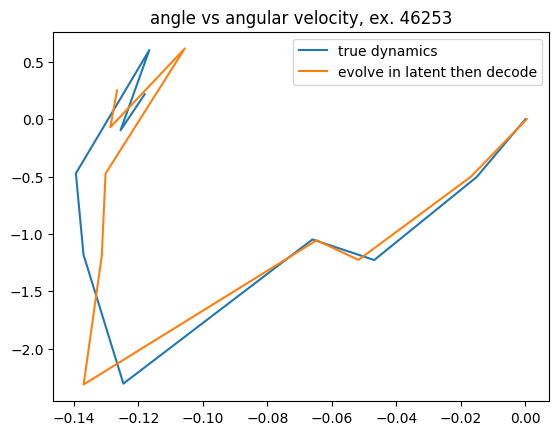

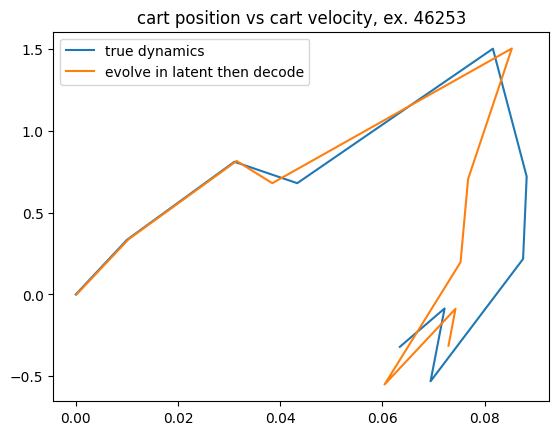

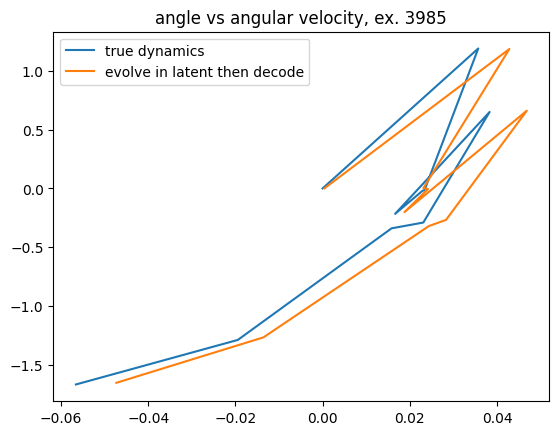

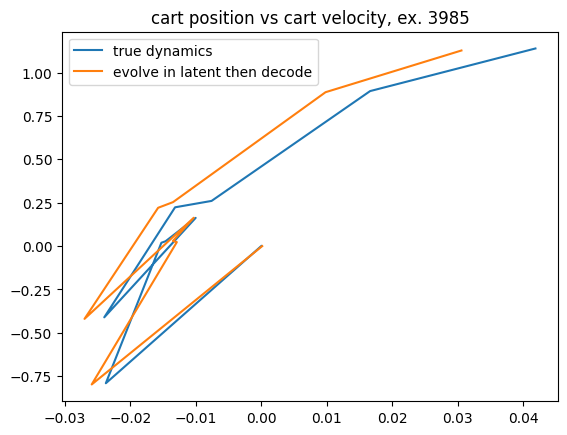

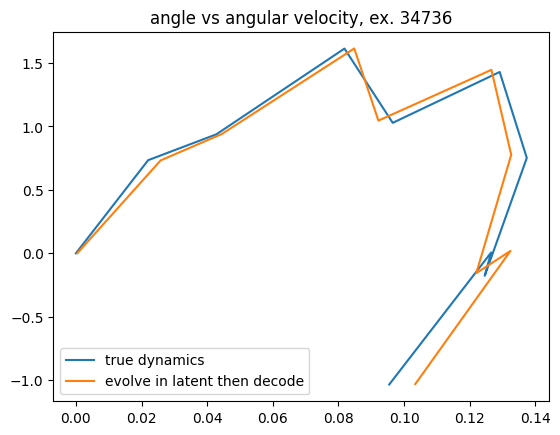

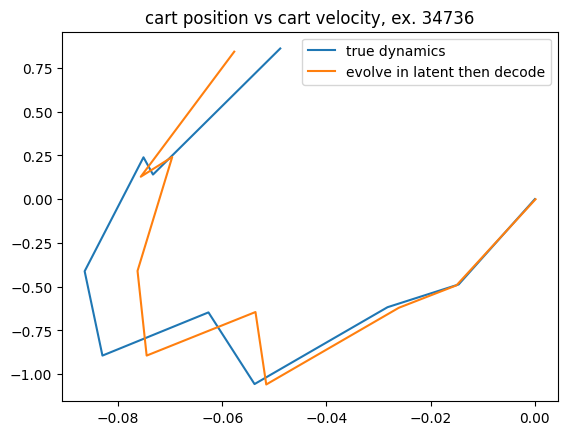

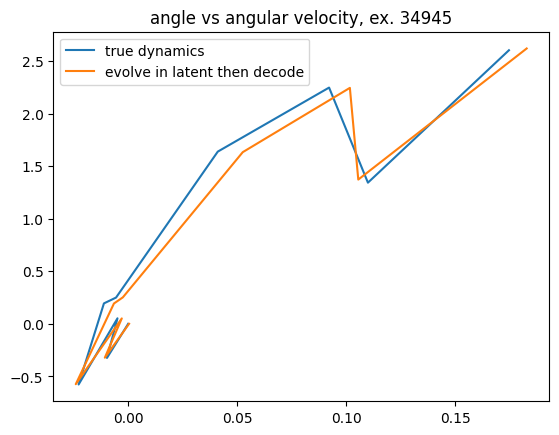

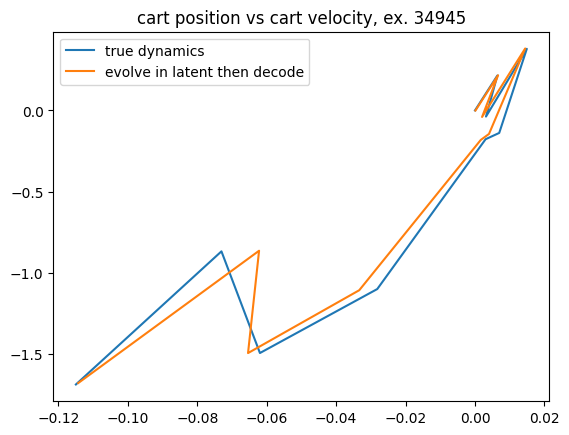

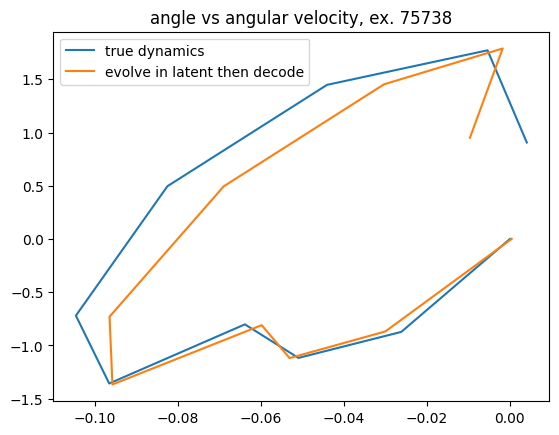

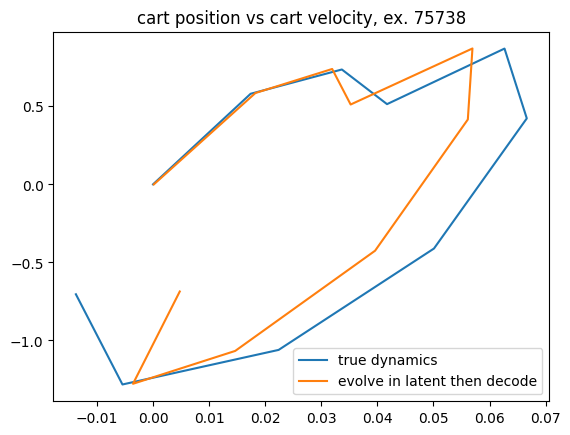

In [8]:
#########################
### Plot Trajectories ###
#########################

plot_trajectories(ae, fdyn, Xtest[0], Utest[0], 5, steps=params.traj_len)#params.m+1)

In [ ]:
######################
### Plot Stability ###
######################

from plotting import plot_stability
n_pts = 5000
eps = np.pi/6 #np.pi/3 
T = 500
tol = np.pi/2
low = [0+-eps, -eps, -eps, -eps]
high = [0+eps, eps, eps, eps]
plot_stability(ae, fdyn, n_pts, low, high, tol, T, visualize=False, latent_traj=True)

In [ ]:
##############################################
### Plot Inverse Image of Latent Norm Ball ###
##############################################

from plotting import plot_preimage_norm_ball

n = 10000
i = 1
j = 2
ivals = [0.]
jvals = [0.]
for ival in ivals:
    for jval in jvals:
        plot_preimage_norm_ball(ae, 0.25, i=i, ival=ival, j=j, jval=jval, n=n) #0.25

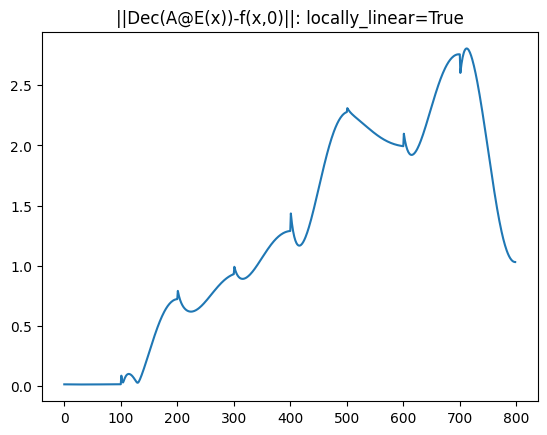

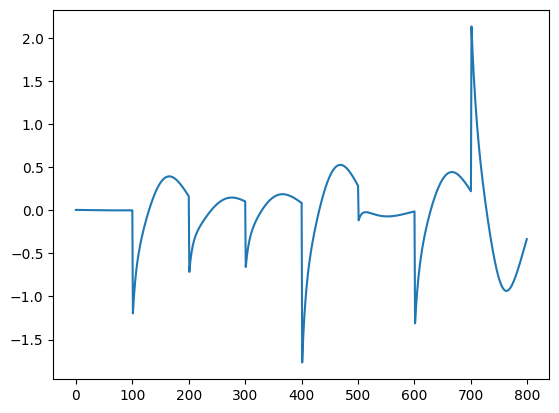

In [6]:
########################
### Stabilize System ###
########################

from controls import LQR

lqr = LQR(ae, fdyn)
stabilize_cartpole(lqr, ae, T=1, tmax=800, stabilize=True)

z_eq tensor([[-0.0007, -0.0041]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 250/250 [00:27<00:00,  9.08it/s]


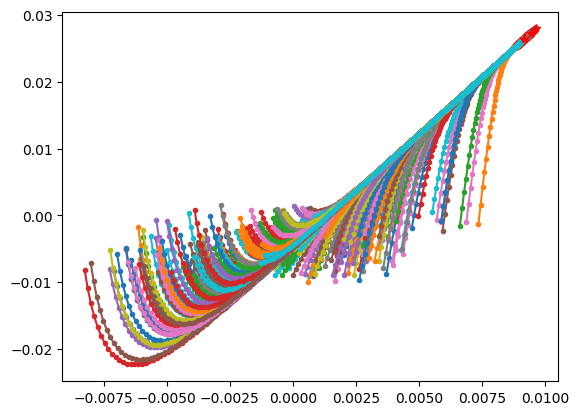

100%|██████████| 250/250 [00:25<00:00,  9.70it/s]


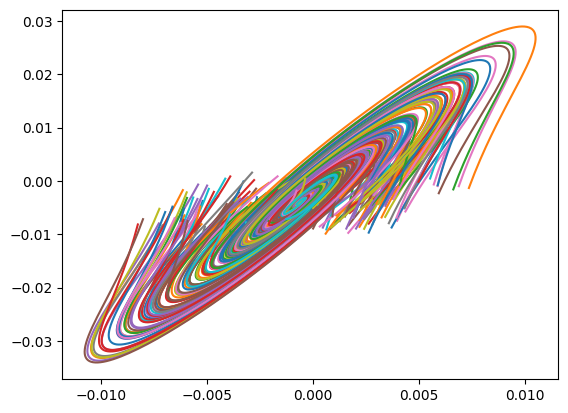

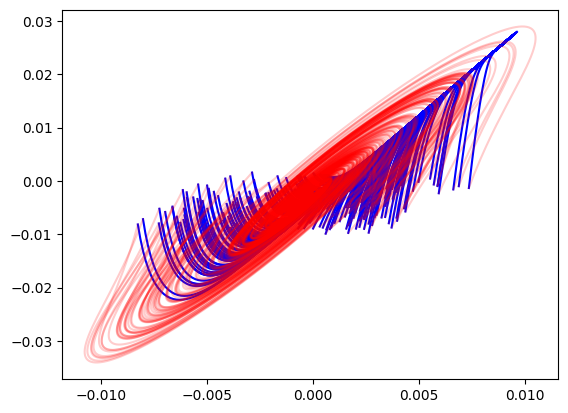

x data (250, 301, 4)
z data (250, 301, 2)
z proj data (250, 301, 2)
u data (250, 300, 1)
gamma forward 0.00047974716
gamma backward 0.14727819


In [8]:
####################################
### Initialize Data for Lyapunov ###
####################################

from plotting import plot_latent_trajectories
from utils import rollout_trajectories

r = 1.2e-1#2e-3 #1e-3
r_test = r #1e-3 #5e-3
rz_init = 0.02 #0.080 #0.005
#rx_init = rz_init
#rz_proj_init = 0.06
n_traj = 250 #3000 #250 350 1000
T = 300
b = ae.encode(torch.tensor(4*[0.,])).cpu().detach().numpy()


for u_cost in [1]:
    lqr = LQR(ae, fdyn, u_cost=u_cost)
    pts, z_data, x_init_cond = plot_latent_trajectories(ae, fdyn, rz_init, n_traj, T=T, plot_quadratic=False, origin_spec=(b, r), lqr=lqr) #r=0.05
    x_data, z_proj_data, u_data, gammas = rollout_trajectories (ae, fdyn, lqr, x_init_cond, plot=True, n_traj=n_traj, T=T)
    gamma_fwd, gamma_bwd = gammas
    
    for zi in z_data:
        plt.plot(zi[:,0], zi[:,1], 'b-')
    for zi in z_proj_data:
        plt.plot(zi[:,0], zi[:,1], 'r-', alpha=0.2)
    plt.show()
    
    u_data = u_data[...,np.newaxis]
    
    #print(pts.shape)
    print("x data", x_data.shape)
    print("z data", z_data.shape)
    print("z proj data", z_proj_data.shape)
    print("u data", u_data.shape)
    print("gamma forward", gamma_fwd)
    print("gamma backward", gamma_bwd)

z_eq: tensor([-0.0007, -0.0041], device='cuda:0', grad_fn=<ViewBackward0>)
pd loss: False
dyn loss: True
lb loss False
grad loss False
rho: 0.9
c lb 0.1
l_dyn 1
l_pd 1
l_lb 1
l_grad 1e-06
using grid data, grid_density: 100
features: 128
coeff: 0.1
LyapunovGeneral(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=False)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=False)
  )
)
it 0: tensor([4.0370e-06], device='cuda:0', grad_fn=<AddBackward0>)


/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


it 1000: tensor([4.0085e-06], device='cuda:0', grad_fn=<AddBackward0>)
it 2000: tensor([4.0082e-06], device='cuda:0', grad_fn=<AddBackward0>)
it 3000: tensor([4.0074e-06], device='cuda:0', grad_fn=<AddBackward0>)
it 4000: tensor([4.0071e-06], device='cuda:0', grad_fn=<AddBackward0>)
alpha 0.00011321635247441009
torch.Size([75250, 2])
Lipschitz constant tensor(0.0190, device='cuda:0', grad_fn=<MaxBackward1>)


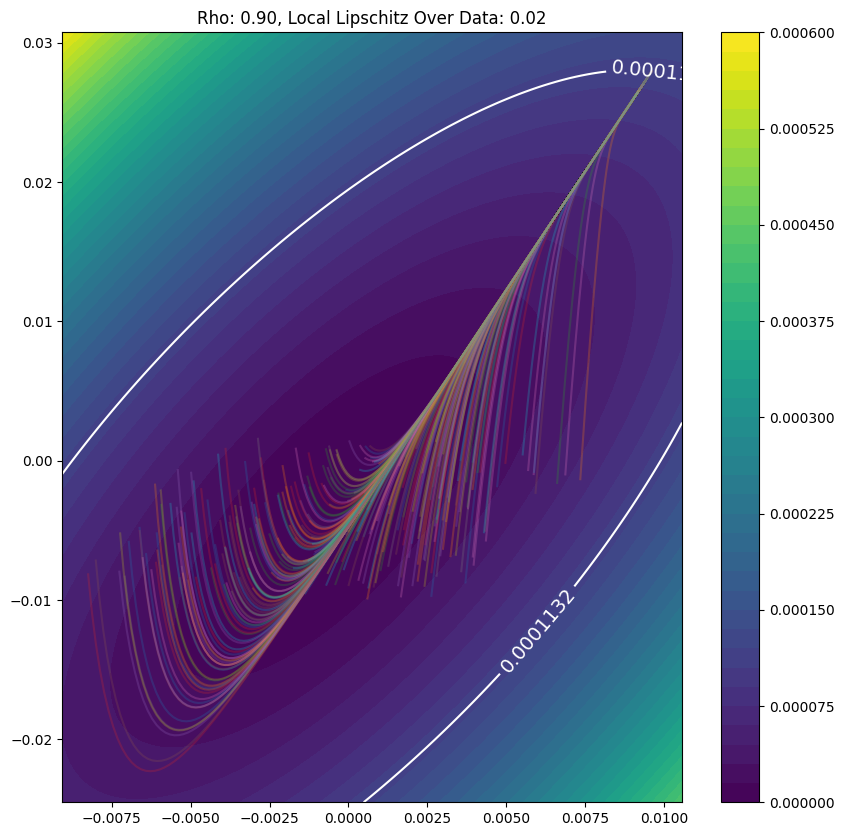

In [9]:
###############################
### Learn Lyapunov Function ###
###############################

from controls import mlp_lyapunov, mlp_lyapunov_reparam
from experiments import load_experiment

z_eq = ae.encode(torch.tensor([0.,0.,0.,0]).float())
#z_eq = torch.tensor([0.,0.]).float()
print("z_eq:", z_eq)
rho = 0.90
V, rho, alpha, lip = mlp_lyapunov_reparam(z_data, epochs=int(0.5e4), lr=2e-4, grid_dens=100, rho=rho, z_eq=z_eq) #ep 3e4

(1997, 4)
1.089025772671448e-06


100%|██████████| 1997/1997 [07:11<00:00,  4.63it/s]


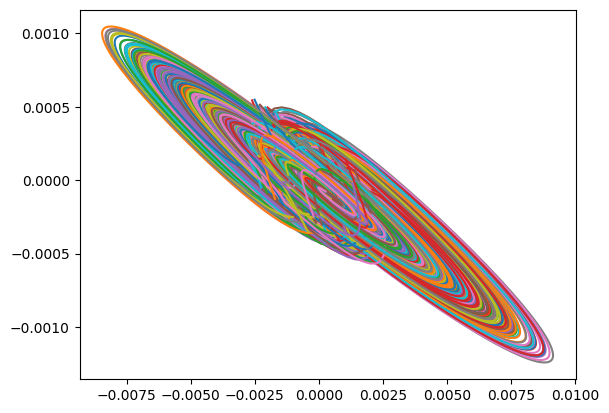

(1997, 201, 2)
gamma fwd: 0.00011700433
L: 0.0017786851385608315
a0: 1.089025772671448e-06
Ly/p: 2.0811385e-06


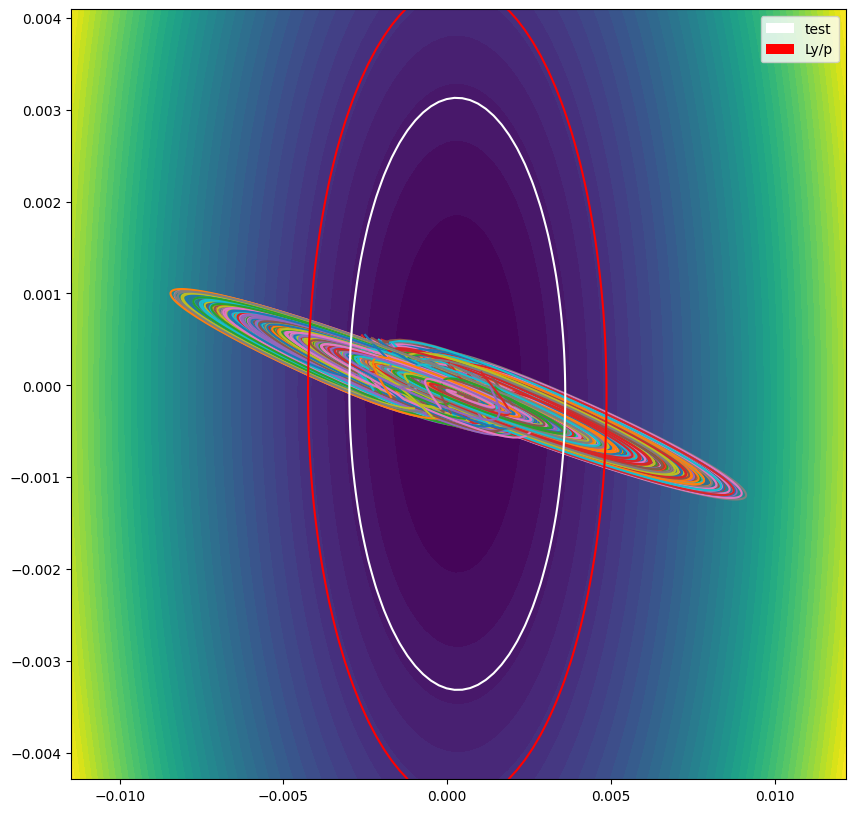

In [25]:
from theorem_tools import compute_preimage, plot_lyapunov_lvlsets

Dx = compute_preimage(ae, z_data, 0.05, 10, uniform_sampling=True)
print(Dx.shape)
a0 = torch.max(V(ae.encode(torch.tensor(Dx)))).cpu().item()
print(a0)
Dz = z_data
plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0)

3000


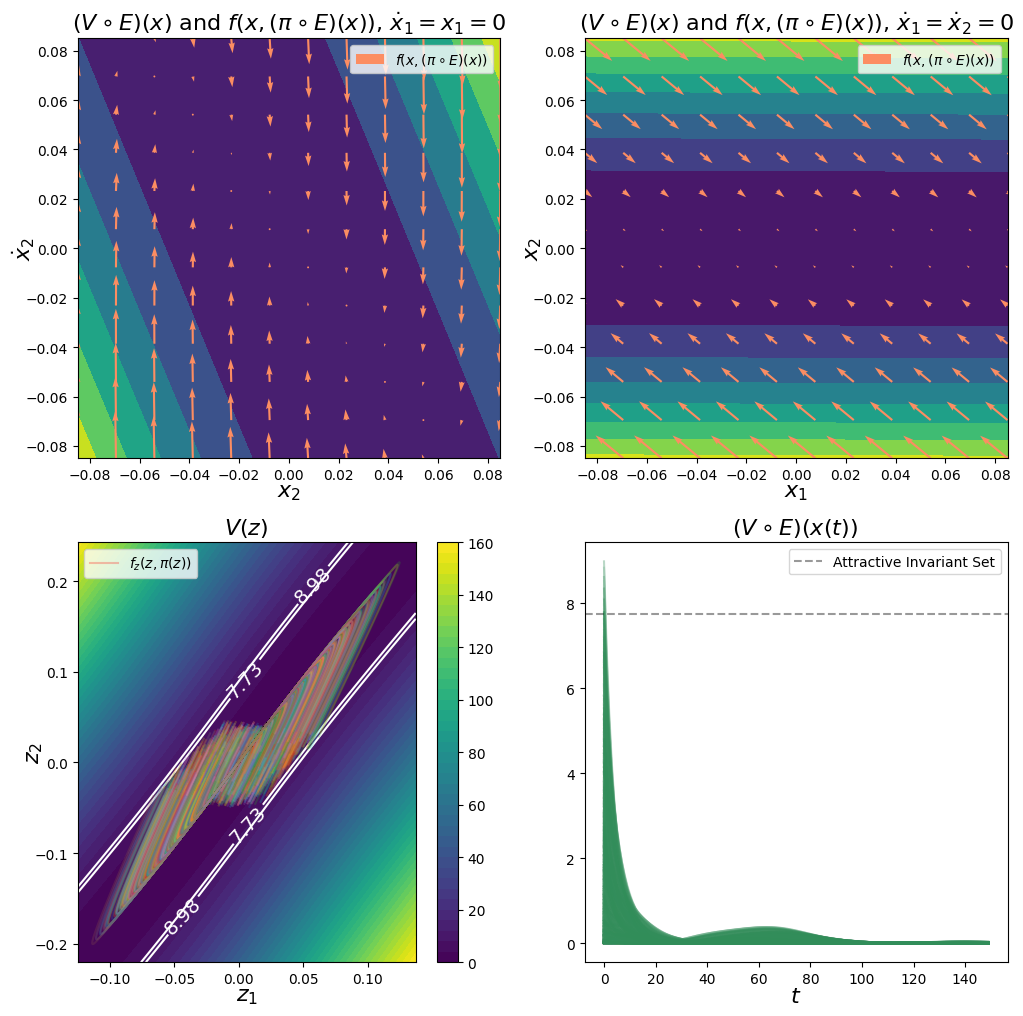

In [28]:
###################
### Make Figure ###
###################


from plotting import plot_lyapunov_slice

lqr = LQR(ae, fdyn)
#plot_lyapunov_slice(V, lqr, ae, (0.5, 0.05), (0.5, 0.05), z_data, z_proj_data)
plot_lyapunov_slice(V, lqr, ae, (rz_init, rz_init), (rz_init, rz_init), z_data, z_proj_data, 7.731, alpha)
#0.001974


In [ ]:
###############################################
### Video: Evolution of Latent Trajectories ###
###############################################


from videos import latent_projections_video
from controls import LQR
lqr = LQR(ae, fdyn)
latent_projections_video(lqr, ae, fdyn, 0.2, T=500, N=9)